In [1]:
import torch
import torch.nn as nn

import pandas as pd
import matplotlib.pyplot as plt

In [297]:
class WassersteinLossCritic(nn.Module):

    def __init__(self):
        super().__init__()
    
    def forward(self, input, target, gradient=None):
        loss = torch.mean(target) - torch.mean(input)
        if gradient is not None:
            loss += torch.sqrt(torch.sum(torch.square(gradients).view(-1)))
        return  loss


class WassersteinLossGenerator(nn.Module):

    def __init__(self):
        super().__init__()
    
    def forward(self, input, target):
        return torch.mean(torch.square(target-input))

In [298]:
class Encoder(nn.Module):

    def __init__(self, signal_shape=100):
        super(Encoder, self).__init__()
        self.signal_shape = signal_shape
        self.lstm = nn.LSTM(input_size=self.signal_shape, hidden_size=20, num_layers=1, bidirectional=True)
        self.dense = nn.Linear(in_features=40, out_features=20)

    def forward(self, x):
        x = x.view(1, 64, self.signal_shape).float()
        x, (hn, cn) = self.lstm(x)
        x = self.dense(x)
        return (x)

class Decoder(nn.Module):
    def __init__(self, signal_shape=100):
        super(Decoder, self).__init__()
        self.signal_shape = signal_shape
        self.lstm = nn.LSTM(input_size=20, hidden_size=64, num_layers=2, bidirectional=True)
        self.dense = nn.Linear(in_features=128, out_features=self.signal_shape)

    def forward(self, x):
        x, (hn, cn) = self.lstm(x)
        x = self.dense(x)
        return (x)

class CriticX(nn.Module):
    def __init__(self, signal_shape=100):
        super(CriticX, self).__init__()
        self.signal_shape = signal_shape
        self.dense1 = nn.Linear(in_features=self.signal_shape, out_features=20)
        self.dense2 = nn.Linear(in_features=20, out_features=1)

    def forward(self, x):
        x = x.view(1, 64, self.signal_shape).float()
        x = self.dense1(x)
        x = self.dense2(x)
        return (x)

class CriticZ(nn.Module):
    def __init__(self):
        super(CriticZ, self).__init__()
        self.dense1 = nn.Linear(in_features=20, out_features=1)

    def forward(self, x):
        x = self.dense1(x)
        return (x)

In [299]:
class SignalDataset(Dataset):
    def __init__(self, path: str):
        self.signal_df = pd.read_csv(path)
        self.signal_columns = self.make_signal_list()
        self.make_rolling_signals()

    def make_signal_list(self):
        signal_list = list()
        for i in range(-50, 50):
            signal_list.append('signal'+str(i))
        return signal_list

    def make_rolling_signals(self):
        for i in range(-50, 50):
            self.signal_df['signal'+str(i)] = self.signal_df['signal'].shift(i)
        self.signal_df = self.signal_df.dropna()
        self.signal_df = self.signal_df.reset_index(drop=True)

    def __len__(self):
        return len(self.signal_df)

    def __getitem__(self, idx):
        row = self.signal_df.loc[idx]
        x = row[self.signal_columns].values.astype(float)
        x = torch.from_numpy(x)
        return {'signal':x, 'anomaly':row['anomaly']}

In [305]:
def criticx_step(x):

    z = torch.empty(1, batch_size, latent_space_dim).normal_(0, 1)
                
    optim_criticx.zero_grad()
    real_pred = criticx(x)
    x_ = decoder(z)
    gen_pred = criticx(x_)
                
    alpha = torch.empty(x.shape).uniform_(0,1)
    interpolated = torch.autograd.Variable(alpha * x + (1-alpha) * x_)
    interpolated.requires_grad_(True)
    validity_interpolated = criticx(interpolated)
    validity_interpolated.mean().backward()
    gradient = interpolated.grad

    crx_loss_step = criticx_loss(gen_pred, real_pred, gradient)
    crx_loss_step.backward()

    optim_criticx.step()

    return crx_loss_step.item()


def criticz_step(x):

    z = encoder(x)
                
    optim_criticz.zero_grad()
    real_pred = criticz(z)
    z_ = torch.empty(1, batch_size, latent_space_dim).normal_(0, 1)
    gen_pred = criticz(z_)
    
    alpha = torch.empty(z.shape).uniform_(0,1)
    interpolated = torch.autograd.Variable(alpha * z + (1-alpha) * z_)
    interpolated.requires_grad_(True)
    validity_interpolated = criticz(interpolated)
    validity_interpolated.mean().backward()
    gradient = interpolated.grad

    crz_loss_step = criticz_loss(gen_pred, real_pred, gradient)
    crz_loss_step.backward()
    optim_criticz.step()

    return crz_loss_step.item()


def encoder_decoder_step(x):

    z = torch.empty(1, batch_size, latent_space_dim).normal_(0, 1)
                
    optim_decoder.zero_grad()

    real_pred = criticx(x)
    x_ = decoder(z)
    gen_pred = criticx(x_)

    crx_loss_step = criticx_loss(gen_pred, real_pred)
    crx_loss_step.backward(retain_graph=True)
    optim_decoder.step()

    optim_encoder.zero_grad()

    z = encoder(x)
                
    real_pred = criticz(z)
    z_ = torch.empty(1, batch_size, latent_space_dim).normal_(0, 1)
    gen_pred = criticz(z_)

    crz_loss_step = criticz_loss(gen_pred, real_pred)
    crz_loss_step.backward(retain_graph=True)
    optim_encoder.step()

    optim_encoder.zero_grad()
    optim_decoder.zero_grad()

    gen_pred = decoder(encoder(x))
    encoder_decoder_loss_step = encoder_decoder_loss(gen_pred, x)
    encoder_decoder_loss_step.backward(retain_graph=True)
    optim_encoder.step()
    optim_decoder.step()

    return encoder_decoder_loss_step.item() + crz_loss_step.item() + crx_loss_step.item()

In [316]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from torch.optim import Adam


num_epoches = 35
batch_size = 64
num_critic = 5
lr = 1e-6

signal_shape = 100
latent_space_dim = 20

data = DataLoader(SignalDataset('data/train.csv'), batch_size=batch_size, shuffle=False, drop_last=True)

encoder = Encoder()
decoder = Decoder()
criticx = CriticX()
criticz = CriticZ()

optim_criticx = Adam(criticx.parameters(), lr=lr, betas=(0.5, 0.999))
optim_criticz = Adam(criticz.parameters(), lr=lr, betas=(0.5, 0.999))
optim_encoder = Adam(encoder.parameters(), lr=lr, betas=(0.5, 0.999))
optim_decoder = Adam(decoder.parameters(), lr=lr, betas=(0.5, 0.999))

criticx_loss = WassersteinLossCritic()
criticz_loss = WassersteinLossCritic()
encoder_decoder_loss = WassersteinLossGenerator()

pbar = tqdm(total=num_epoches)

with pbar:

    losses = {'criticx': [], 'criticz': [], 'encoder_decoder': []}

    for epoch in range(1, num_epoches+1):

        losses_per_epoch = {'criticx': [], 'criticz': [], 'encoder_decoder': []}

        for k in range(1, num_critic+1):
            for batch, sample in enumerate(data):

                x = sample['signal'].view(1, batch_size, signal_shape)
                
                crx_loss_step = criticx_step(x)
                losses_per_epoch['criticx'].append(crx_loss_step)

                crz_loss_step = criticz_step(x)
                losses_per_epoch['criticz'].append(crz_loss_step)

        for batch, sample in enumerate(data):

            x = sample['signal'].view(1, batch_size, signal_shape)
                
            crx_loss_step = criticx_step(x)
            losses_per_epoch['criticx'].append(crx_loss_step)

            crz_loss_step = criticz_step(x)
            losses_per_epoch['criticz'].append(crz_loss_step)

            encoder_decoder_loss_step = encoder_decoder_step(x)
            losses_per_epoch['encoder_decoder'].append(encoder_decoder_loss_step)
                
        for key in losses.keys():
            losses[key].append(np.mean(losses_per_epoch[key]))        
                
        
        pbar.update()

    #print(crx_loss_step.item(), crz_loss_step.item(), encoder_decoder_loss_step.item(), sep='\t')

100%|██████████| 35/35 [04:36<00:00,  7.89s/it]


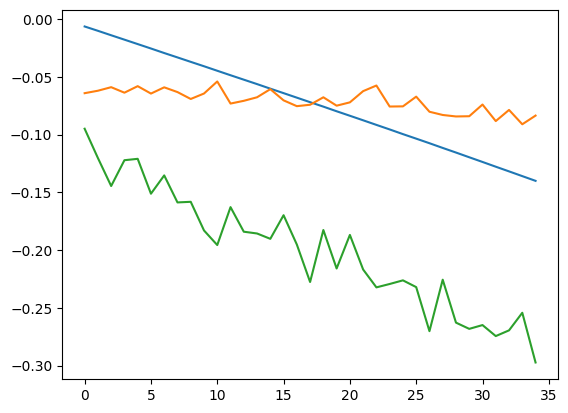

In [317]:
for key in losses.keys():
    plt.plot(losses[key])

plt.show()

In [318]:
sample = next(iter(data))
x = sample['signal'].view(1, batch_size, signal_shape)
z = torch.empty(1, batch_size, latent_space_dim).normal_(0, 1)

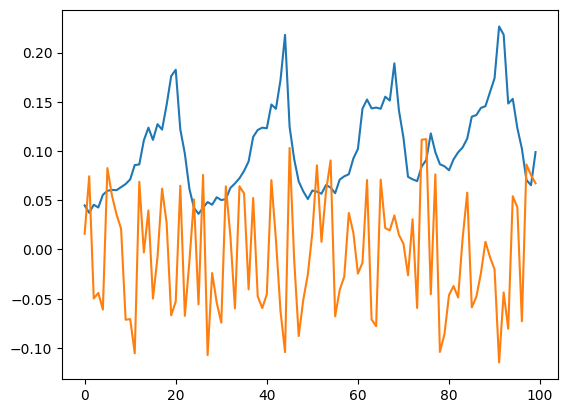

In [319]:
x_hat = decoder(encoder(x))
err = torch.abs(x - x_hat)

plt.plot(x[0,1])
plt.plot(x_hat.detach().numpy()[0,1])
plt.show()

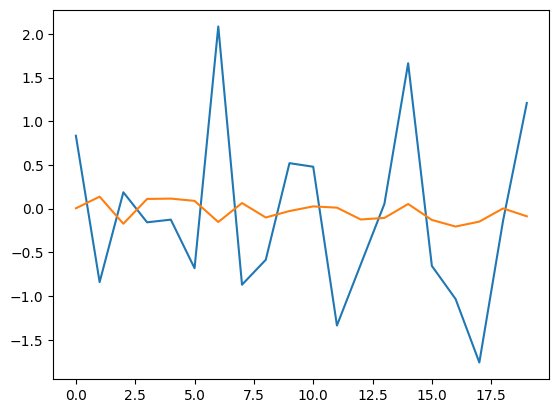

In [320]:
z_hat = encoder(decoder(z))
err = torch.abs(z - z_hat)

plt.plot(z[0,1])
plt.plot(z_hat.detach().numpy()[0,1])
plt.show()